# Model training, testing and selection

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold


In [4]:
data = pd.read_csv('../data/cleaned_data.csv')

In [5]:
X = data.drop('price', axis=1)
y = data['price']

X_work, X_test, y_work, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_work, y_work, test_size=0.2 ,random_state=42)

In [6]:
def safe_mape(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_idx = np.abs(y_true) > epsilon
    if not np.any(non_zero_idx):
        return np.nan  # or some fallback value
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100


In [7]:
def evaluate_model(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': safe_mape(y_test, y_pred)
        }
    return pd.DataFrame(results).T.sort_values(by='R2', ascending=False)


In [8]:

def visualize_results(results_df):
    """
    Visualizes evaluation metrics of models using individual bar plots per metric.
    """
    # Set plot style
    sns.set(style="whitegrid")

    # Reshape results for plotting
    results_melted = results_df.reset_index().melt(id_vars='index', 
                                                   var_name='Metric', 
                                                   value_name='Value')
    results_melted.rename(columns={'index': 'Model'}, inplace=True)

    # Plot each metric separately
    unique_metrics = results_melted['Metric'].unique()
    for metric in unique_metrics:
        metric_data = results_melted[results_melted['Metric'] == metric]

        plt.figure(figsize=(10, 5))
        sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')
        plt.title(f'{metric} by Model')
        plt.ylabel(metric)
        plt.xlabel('Model')
        plt.xticks(rotation=45)

        # Annotate values on bars
        for i, row in metric_data.iterrows():
            plt.text(i % len(metric_data['Model'].unique()), row['Value'], 
                     f"{row['Value']:.2f}", ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()


In [9]:
def plot_predictions(models, X_test, y_test):
    """
    Generate scatter plots of actual vs. predicted values for each model.
    """
    n_models = len(models)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))

    plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    sns.set(style="whitegrid")

    for idx, (name, model) in enumerate(models.items(), 1):
        y_pred = model.predict(X_test)

        plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, s=40)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # perfect fit line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{name} - Actual vs Predicted")
        plt.tight_layout()

    plt.suptitle("Scatter Plots: Actual vs Predicted", fontsize=16, y=1.02)
    plt.show()

## 1. Round 1 - Initial model comparisson

In [10]:
LR = LinearRegression()
DT = DecisionTreeRegressor(random_state=42)
RF = RandomForestRegressor(random_state=42)
SVR = SVR()
KNN = KNeighborsRegressor()
XGB = xgb.XGBRegressor(random_state=42)

LR.fit(X_train, y_train)
DT.fit(X_train, y_train)    
RF.fit(X_train, y_train)
SVR.fit(X_train, y_train)
KNN.fit(X_train, y_train)
XGB.fit(X_train, y_train)

models = {
    'Linear Regression': LR,
    'Decision Tree': DT,
    'Random Forest': RF,
    'Support Vector Regression': SVR,
    'K-Nearest Neighbors': KNN,
    'XGBoost': XGB
}

results = evaluate_model(models, X_test, y_test)
results

,R2,MSE,RMSE,MAE,MAPE
Linear Regression,0.608461,5.970915e+10,244354.559328,136212.931610,25.810055
XGBoost,0.591038,6.236605e+10,249731.959200,116622.005083,20.096050
Random Forest,0.588351,6.277589e+10,250551.174355,116065.394497,20.424361
K-Nearest Neighbors,0.557312,6.750919e+10,259825.303042,118683.257265,20.836936
Decision Tree,0.179970,1.250533e+11,353628.720264,164784.774271,28.570741
Support Vector Regression,-0.056743,1.611517e+11,401437.023286,238210.567218,44.220622


C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


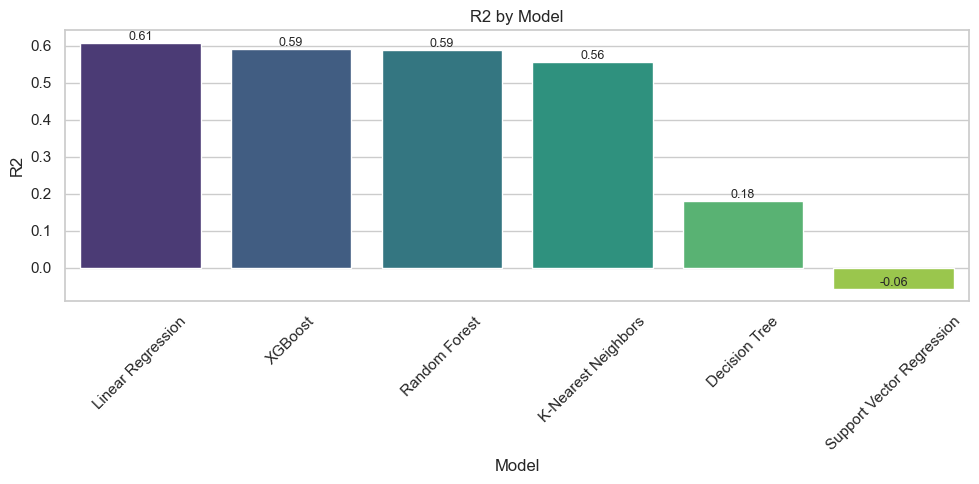

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


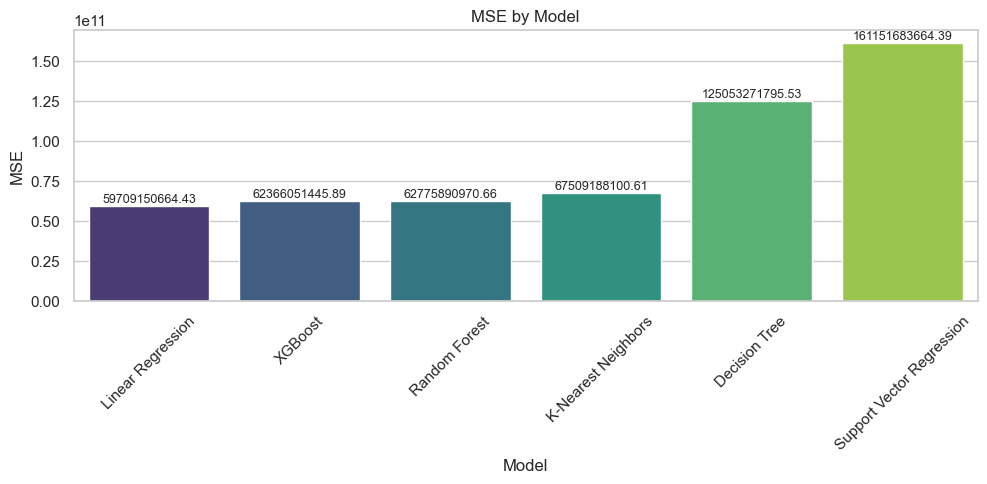

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


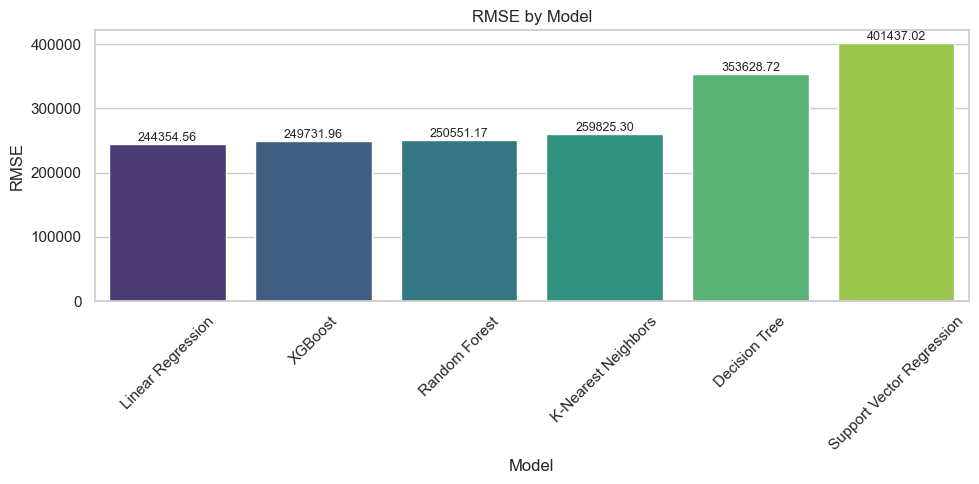

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


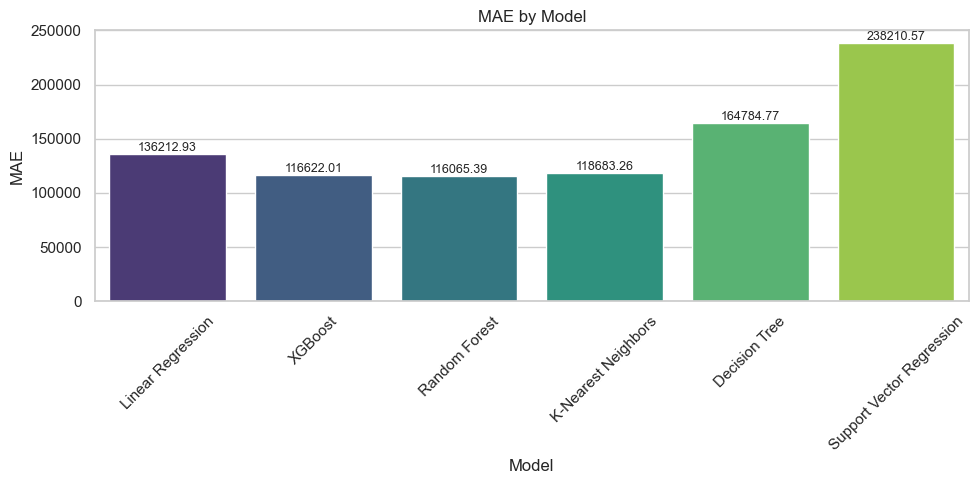

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


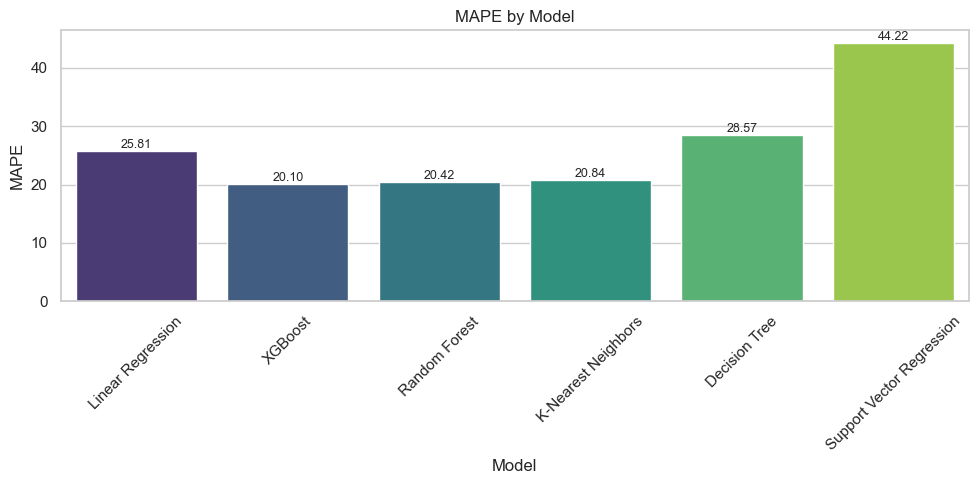

In [11]:
visualize_results(results)

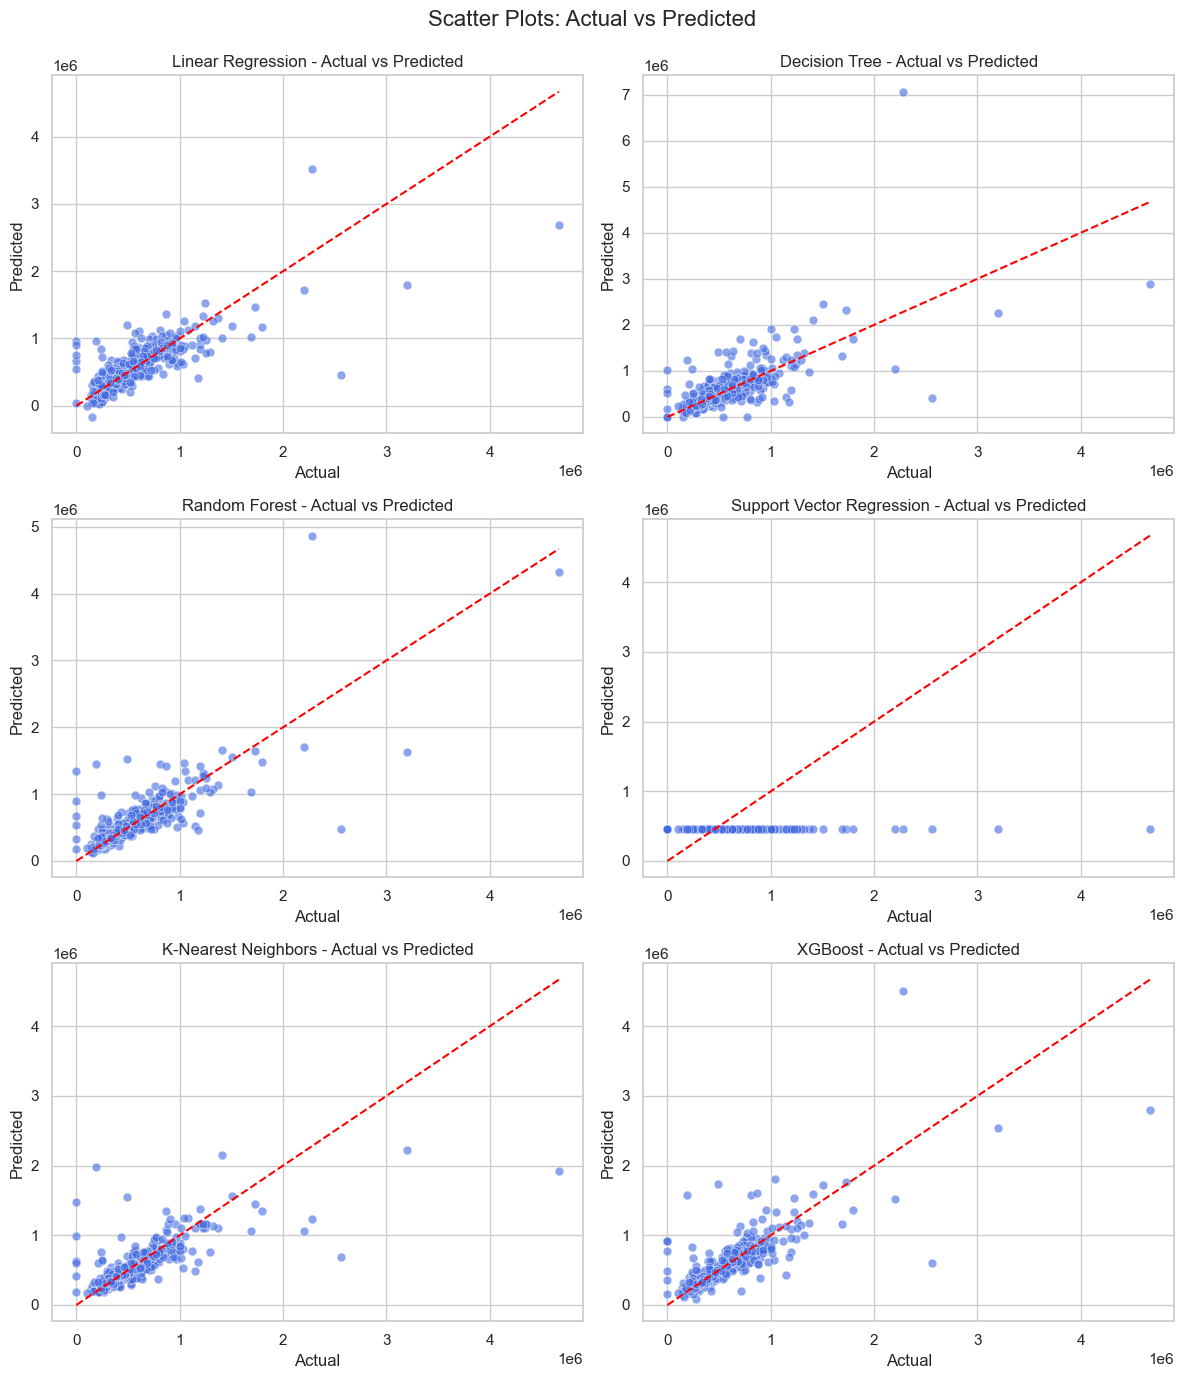

In [12]:
plot_predictions(models, X_test, y_test)

## 2. Round 2 - Hyperparameter optimization

In [18]:
def run_randomized_search(models, X_train, y_train, cv_splitter, n_iter=30):
    """
    Run RandomizedSearchCV on provided models and param grids,
    return best estimators in a dict.
    
    Args:
        models (dict): {model_name: (estimator, param_grid)}
        X_train, y_train: training data
        cv_splitter: cross-validation splitter (e.g. KFold object)
        n_iter (int): number of iterations for RandomizedSearchCV
    
    Returns:
        dict: best estimators keyed by model name
    """
    best_estimators = {}

    for name, (model, params) in models.items():
        print(f"Running RandomizedSearchCV for {name}...")
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=n_iter,
            scoring='neg_mean_squared_error',
            cv=cv_splitter,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_estimators[name] = search.best_estimator_

        print(f"Best score (neg MSE) for {name}: {search.best_score_:.4f}")
        print(f"Best estimator for {name}:\n{search.best_estimator_}\n")

    return best_estimators

In [19]:
from sklearn.model_selection import KFold

# Your parameter grids here (same as before)
rf_params = {
    'n_estimators': np.arange(50, 300, 25),
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

dt_params = {
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

xgb_params = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 15),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

knn_params = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

lr_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

models = {
    'RandomForest': (RandomForestRegressor(), rf_params),
    'DecisionTree': (DecisionTreeRegressor(), dt_params),
    'XGBoost': (xgb.XGBRegressor(verbosity=0), xgb_params),
    'KNN': (KNeighborsRegressor(), knn_params),
    'LinearRegression': (LinearRegression(), lr_params)
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Run RandomizedSearchCV and get best models
best_estimators = run_randomized_search(models, X_train, y_train, kfold, n_iter=30)

# Now best_estimators is a dict you can use for further comparison or evaluation

Running RandomizedSearchCV for RandomForest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    validat

Best score (neg MSE) for RandomForest: -55232217514.7232
Best estimator for RandomForest:
RandomForestRegressor(max_depth=np.int64(18), max_features='sqrt',
                      min_samples_split=5, n_estimators=np.int64(200))

Running RandomizedSearchCV for DecisionTree...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    valida

Best score (neg MSE) for DecisionTree: -77751776515.3864
Best estimator for DecisionTree:
DecisionTreeRegressor(max_depth=np.int64(13), max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5)

Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score (neg MSE) for XGBoost: -52308942100.4468
Best estimator for XGBoost:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=np.int64(5),
             max_leaves=None, min_child_we

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [20]:
evaluate_model(best_estimators, X_val, y_val)

,R2,MSE,RMSE,MAE,MAPE
RandomForest,0.631421,3.941897e+10,198542.123512,109858.375726,22.067452
LinearRegression,0.614387,4.124066e+10,203077.963997,127452.643387,25.045198
KNN,0.602083,4.255660e+10,206292.517230,108504.381776,22.969311
XGBoost,0.580476,4.486746e+10,211819.394585,106629.751931,20.100669
DecisionTree,0.369570,6.742351e+10,259660.383713,146274.845544,28.030896


C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


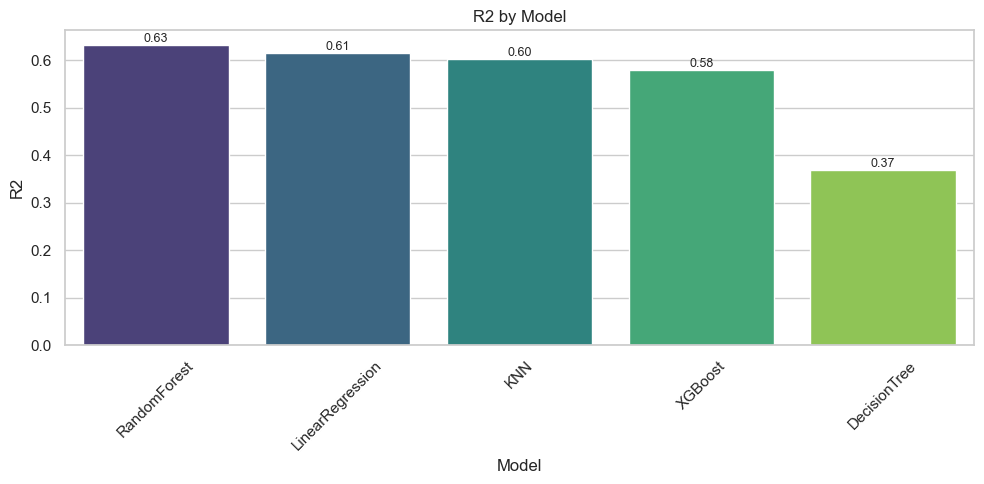

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


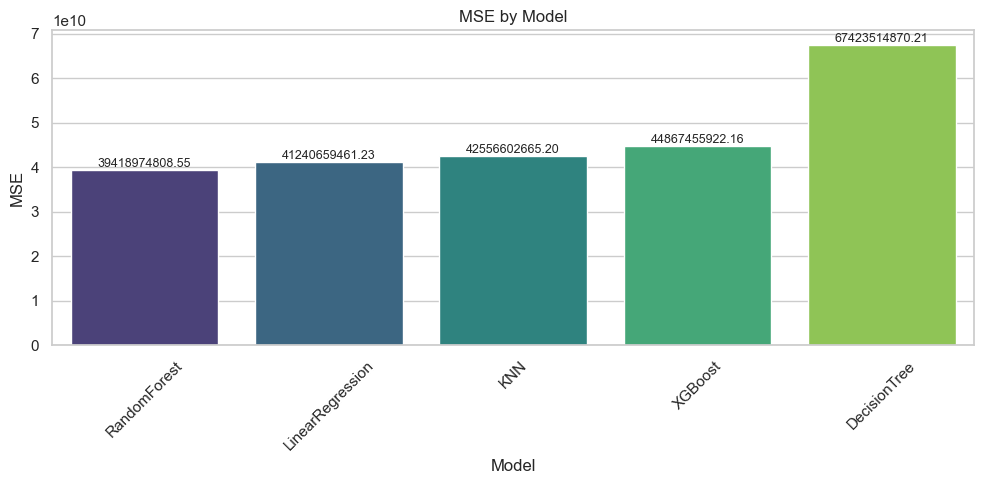

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


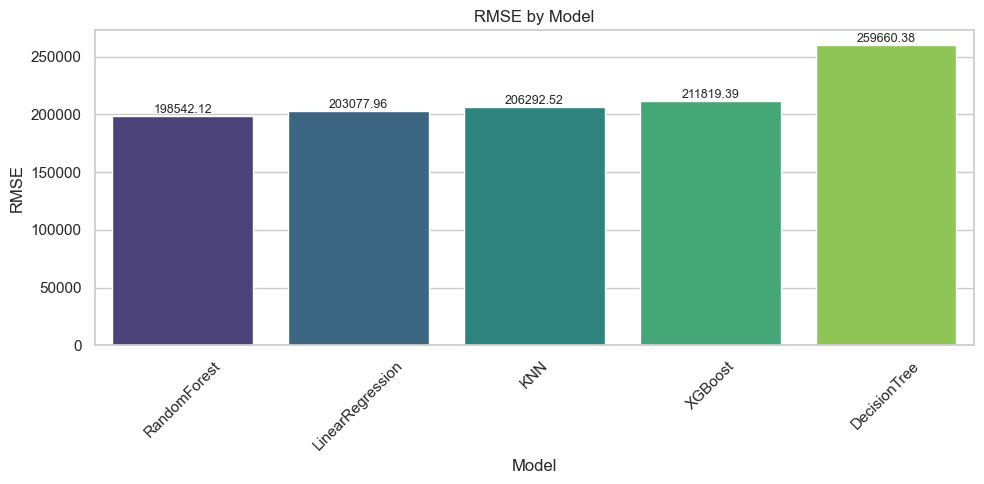

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


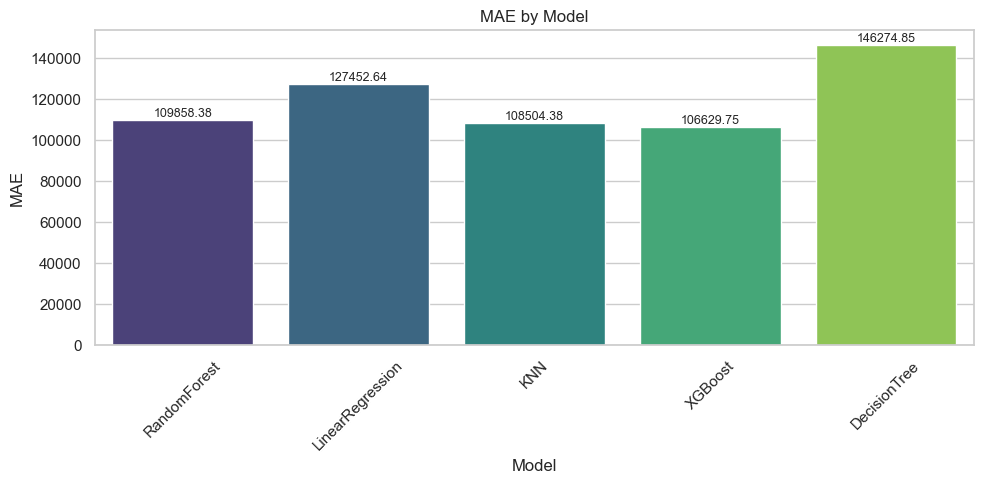

C:\Users\david\AppData\Local\Temp\ipykernel_10760\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


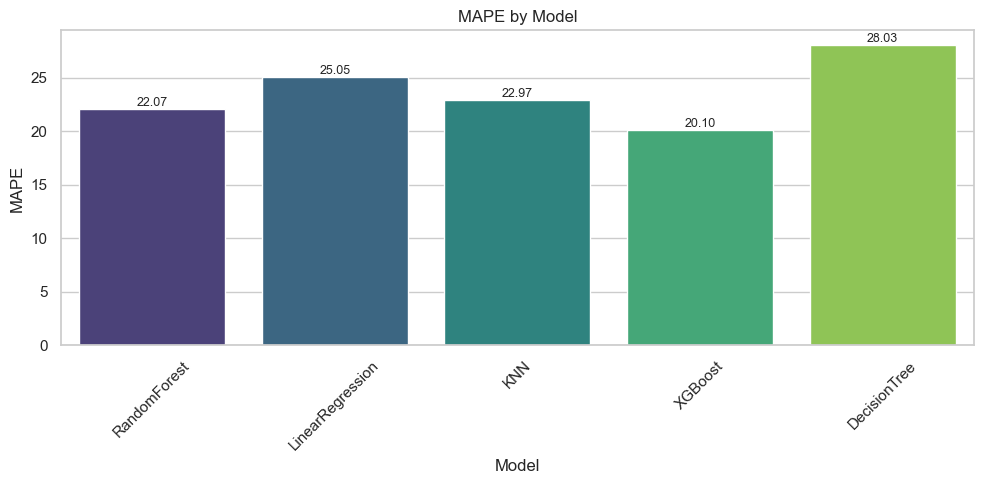

In [21]:
visualize_results(evaluate_model(best_estimators, X_val, y_val))

## 3. Round 3 - 

## 4. Model Testing and final thoughts